### Installing Kaggle API

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shoaibhoque","key":"56d2243436039c0f4b459bf4670bfece"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


to store the data we will create a new directory and make it as current working directory

### Get the data from Kaggle

In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           5866          8  0.1764706        


In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
100% 688M/691M [00:37<00:00, 21.2MB/s]
100% 691M/691M [00:38<00:00, 19.1MB/s]
/content


In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

### Import Neccessary Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

## Data Preprocessing

### Loading the Dataset


In [9]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
labels_all

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


Visualize number of each breeds

In [19]:
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts_hundred = breed_counts[breed_counts>114]
breed_counts_hundred

breed
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
Name: count, dtype: int64

In [20]:
breed_counts_hundred.index

Index(['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher'], dtype='object', name='breed')

In [21]:
labels = labels_all[(labels_all['breed'].isin(breed_counts_hundred.index))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


### Encoding the Data

In [22]:
# Creating numpy matrix with zeros
X = np.zeros((len(labels), 224, 224, 3), dtype='float32')

# One Hot Encoding
y = label_binarize(labels['breed'], classes= breed_counts_hundred.index)

# convert image into numpy array and normalize it
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224,224))
  img = image.img_to_array(img)
  x_data = np.expand_dims(img.copy(), axis = 0)
  X[i] = x_data / 255.0


100%|██████████| 474/474 [00:01<00:00, 471.99it/s]


## Building the Model

In [23]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer= 'l2'))
model.add(Dense(64, activation = 'relu', kernel_regularizer='l2'))
model.add(Dense(len(breed_counts_hundred.index), activation= 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)       

#### Split data for train and test

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

### Train the data

In [25]:
epochs = 100
batch_size = 128

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, y_val))

Epoch 1/100
3/3 [==============================] - 10s 4s/step - loss: 5.1776 - accuracy: 0.2471 - val_loss: 5.1497 - val_accuracy: 0.2558
Epoch 2/100
3/3 [==============================] - 1s 216ms/step - loss: 5.1398 - accuracy: 0.2441 - val_loss: 5.1142 - val_accuracy: 0.2674
Epoch 3/100
3/3 [==============================] - 1s 215ms/step - loss: 5.1020 - accuracy: 0.2441 - val_loss: 5.0794 - val_accuracy: 0.2674
Epoch 4/100
3/3 [==============================] - 1s 258ms/step - loss: 5.0645 - accuracy: 0.2471 - val_loss: 5.0421 - val_accuracy: 0.2674
Epoch 5/100
3/3 [==============================] - 1s 216ms/step - loss: 5.0275 - accuracy: 0.2529 - val_loss: 5.0063 - val_accuracy: 0.2558
Epoch 6/100
3/3 [==============================] - 1s 218ms/step - loss: 4.9903 - accuracy: 0.2588 - val_loss: 4.9723 - val_accuracy: 0.2558
Epoch 7/100
3/3 [==============================] - 1s 221ms/step - loss: 4.9533 - accuracy: 0.2618 - val_loss: 4.9385 - val_accuracy: 0.2558
Epoch 8/100
3/3

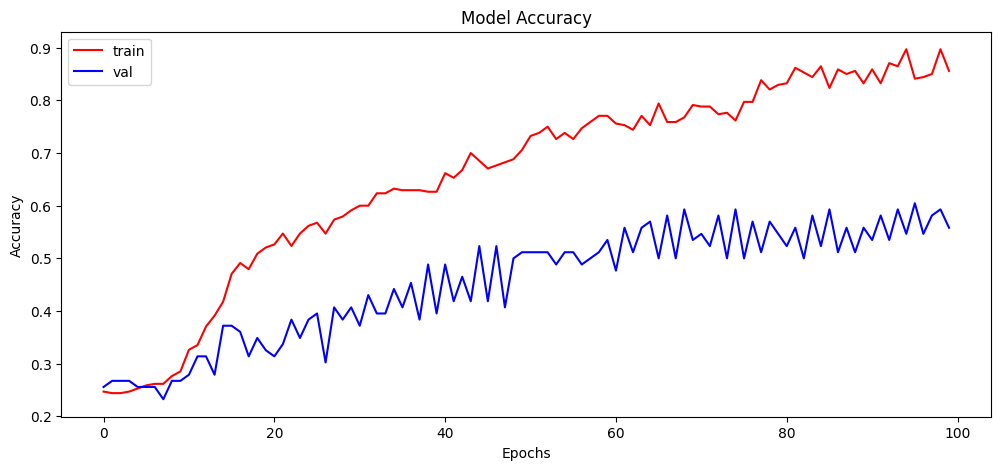

In [26]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color = 'r')
plt.plot(history.history['val_accuracy'], color = 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [27]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)

print('Accuracy over the test set: \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 14ms/step - loss: 2.9536 - accuracy: 0.6042
Accuracy over the test set: 
 60.42 %


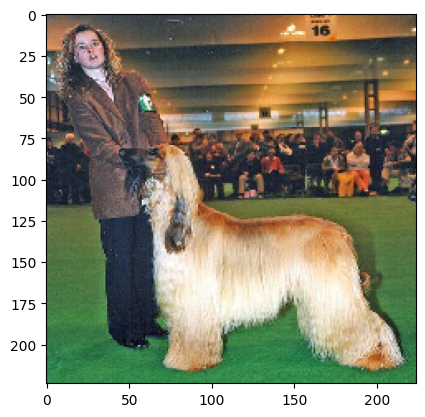

Originally:  scottish_deerhound
Predicted:  scottish_deerhound


In [28]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

print("Originally: ", labels['breed'][np.argmax(y_test[1])])
print("Predicted: ", labels['breed'][np.argmax(y_pred[1])])

In [29]:
model.save("dog_breed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
